Adapted from code by Aneesha Bakharia [here](https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229)

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='gensim' )
import gensim
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models.fasttext import FastText as FT_gensim
%matplotlib inline

In [2]:
model = FT_gensim.load("model/model_cuneiform.model")

In [3]:
with open("output/ogsl.p", "rb") as p:
    o = pickle.load(p)
d = dict(zip(o["value"], o["utf8"]))

In [4]:
def cun(text): 
    """transform transliterated input into cuneiform. Use unicode subscript numbers and separate all signs with hyphens; separate words with blanks
    Examples: 'ma-an-gi₄'; 'd-en-lil₂ nibru-ki'.
    Transliteration style (sugal₇ vs. sukkal; dug₄ vs. du₁₁; gen vs. ŋen; etc.) and capitalization are unimportant.
    """
    cun_line = []
    words = text.lower().split()
    for word in words: 
        signs = word.lower().split('-')
        seq = [d[s] if s in d else s for s in signs]
        seq = ''.join(seq)
        cun_line.append(seq)
    line = ' '.join(cun_line)
    return(line)

In [21]:
def tsne_plot(model, words, cun=False, fontsize=12):
    "Creates a TSNE model and plots it"
    "adapted from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne"
    """model is a word embedding model. 
    The variable words is a dictionary of words taken from the model; the value
    of each word is a category label, an integer between 0 and 5"""
    if cun:
        cunfont = {'fontname':'CuneiformOB'}
    else:
        cunfont = {'fontname' : 'DejaVu'}
    labels = []
    tokens = []
    categories = []
    
    for word in words:
        tokens.append(model.wv[word])
        labels.append(word)
        categories.append(words[word])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    color_d = {0: "black", 1: "green", 2: "blue", 3: "red", 4: "yellow", 5: "brown"}
    
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.plot(x[i],y[i], 'o', color="black")
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     **cunfont,
                     fontsize=fontsize,
                     color = color_d[categories[i]])
    plt.show()

In [22]:
def word_categories(model, words, topn=10):
    """word_categories takes an iterable with one or more words from the vocabulary of model.
    For each word a dictionary of similar words (with the target word) is construed.
    The value of each word is numerical (integer) and indicates the category to which it belongs.
    The function returns a dictionary."""
    word_d = {}
    for idx, word in enumerate(words):
        w = model.wv.most_similar(word, topn=topn)
        w = [m[0] for m in w]
        w.append(word)
        for item in w:
            word_d[item] = idx
    return word_d

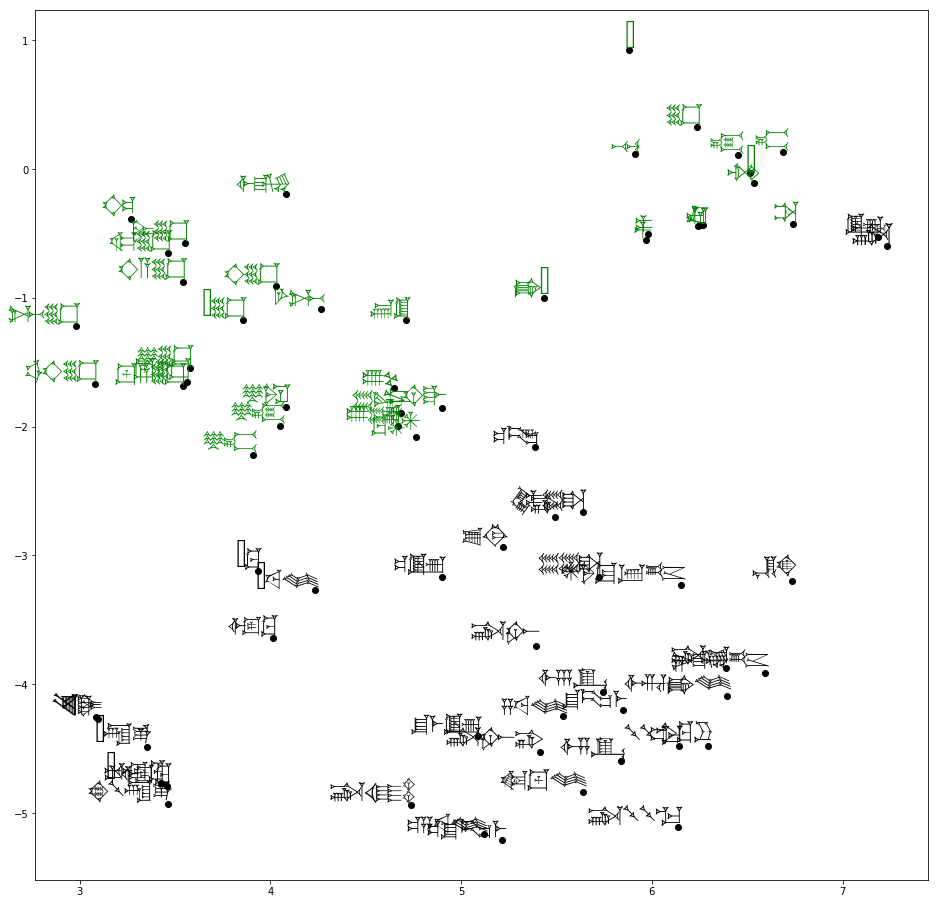

In [23]:
words_d = word_categories(model, [cun("šim-gig"), cun("hi-sar")], 35)
tsne_plot(model, words_d, True, 20)

In [9]:
model2 = FT_gensim.load("model/model_lemm.model")

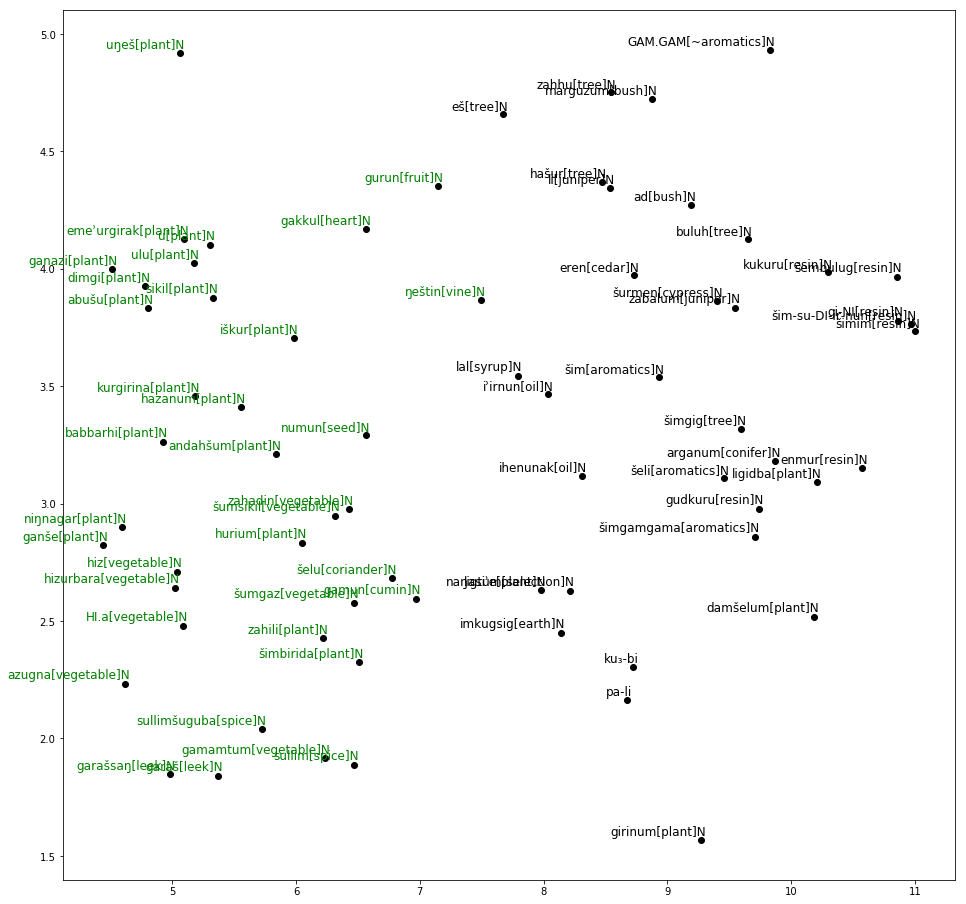

In [10]:
words_d = word_categories(model2, ["šimgig[tree]N", "hiz[vegetable]N"], 35)
tsne_plot(model2, words_d)

In [25]:
words_d

{'𒊺𒇷': 0,
 '𒄞𒆪𒊒': 0,
 '𒋗𒌫𒈨': 0,
 '𒋆𒃵𒃵𒈠': 0,
 '𒋢𒁲': 0,
 '𒋆𒅎': 0,
 '𒍝𒁀𒈝': 0,
 '𒃵𒃵𒈠': 0,
 '𒉺𒅇𒆪': 0,
 '𒇴𒃲': 0,
 '𒉌𒄄𒌈': 0,
 '𒇴𒌉': 0,
 '𒄵𒃵𒆷𒂊': 0,
 '𒋆𒃷': 0,
 '𒅆𒐋𒅅': 0,
 '𒄑𒍝𒁀𒈝': 0,
 '𒋆𒅎𒁉': 0,
 '𒉺𒇷': 0,
 '𒄑𒋗𒌫𒈨': 0,
 '𒅈𒂵𒈝': 0,
 '𒂗𒄯': 0,
 'X𒅇𒆪': 0,
 '𒅇𒆪': 0,
 '𒄑𒂞': 0,
 '𒆬𒁉': 0,
 '𒋗𒈨𒂞': 0,
 '𒀭𒊩𒌆𒅁𒌈': 0,
 '𒂞': 0,
 '𒋎': 0,
 'X𒆷𒂊': 0,
 '𒅮𒇻𒈝': 0,
 'X𒁀𒈝': 0,
 '𒅆𒐉𒅅': 0,
 '𒄑𒌬': 0,
 'X𒆪': 0,
 '𒋆𒈪𒉭': 0,
 '𒌓𒄭𒊬': 1,
 '𒃻𒉄': 1,
 '𒆰': 1,
 '𒌑𒆳': 1,
 '𒆪𒀯': 1,
 '𒄤': 1,
 '𒊺𒇽': 1,
 '𒋧𒊬': 1,
 '𒋧𒄤': 1,
 '𒓊': 1,
 '𒇻𒀀𒊬': 1,
 '𒃷𒂠': 1,
 '𒅆𒄄': 1,
 '𒄭𒀀𒊬': 1,
 '𒋧𒂖': 1,
 '𒊕𒊬': 1,
 '𒌑𒌁': 1,
 '𒄭𒄑': 1,
 '𒋧𒄣': 1,
 '𒌉𒊬': 1,
 '\U00012547': 1,
 'X𒊬': 1,
 '𒋭': 1,
 '𒁵': 1,
 '𒇻𒊬': 1,
 '𒉄𒊬': 1,
 '𒑏': 1,
 '𒂵X': 1,
 '𒑛': 1,
 '𒈦': 1,
 '𒑚': 1,
 '𒑐': 1,
 '𒊬': 1,
 '𒄣': 1,
 '𒄘𒃲': 1,
 '𒄭𒊬': 1}